# Modelo de regressão logística com dados balanceados

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

In [2]:
df_fam_featured = pd.read_csv('../Data_modelo/df_modelo_balanceado.csv')

In [3]:
df_fam_featured = df_fam_featured.rename(columns={'pct_deficientes':'pct_pcd'})

In [4]:
df_fam_featured = df_fam_featured.drop('id_familia', axis=1)

In [5]:
df_fam_featured.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam', 'ind_parc_mds_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao',
       'classe_renda', 'rf_idade', 'rf_trab_principal', 'rf_com_deficiencia',
       'rf_trab_agricultura', 'rf_sexo', 'rf_curso_frequentou',
       'rf_curso_frequenta', 'rf_trabalhou_semana', 'rf_cor_raca',
       'rf_concluiu_curso', 'pct_extrativista', 'pct_conta_propria',
       'pct_trab_rural_temporario', 'pct_empregado_sem_carteira',
       'pct_empregado_com_carteira', 'pct_trab_domestico_sem_carteira',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca',
       'pct_nao_alfabetizados', 'pct_n_freq_escola', 'pct_freq_publica',
       'pct_freq_particular', 'pct_adulto_nunca_freq_escola',
       'pct_escolar_nunca_freq_escola', 'pct_freq_creche', 'pct_idosos',
       'pct_pcd', 'pct_1

In [6]:
df_fam_featured.head()

,uf_ibge,classf,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,ind_parc_mds_fam,qtde_pessoas,dias_cadastramento,dias_atualizacao,...,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_pcd,pct_1_infancia,pct_adulto,pct_crianca_adolescente,ind_parc_mds_fam_0_1,ideb_2017_municipio
0,15,1,1.0,2.0,2.0,1.0,0.0,3,3290.0,510,...,0.333333,0.0,0.0,0.0,0.000,0.000000,0.333333,0.666667,0.0,4.8
1,13,3,1.0,4.0,2.0,1.0,0.0,8,1774.0,101,...,0.000000,0.0,0.0,0.0,0.375,0.375000,0.250000,0.375000,0.0,4.6
2,29,3,2.0,4.0,2.0,1.0,205.0,2,1966.0,598,...,0.000000,0.5,0.0,0.0,0.000,0.000000,0.500000,0.500000,1.0,4.0
3,28,3,2.0,5.0,2.0,1.0,0.0,2,812.0,285,...,0.000000,0.0,0.0,0.0,0.000,0.500000,0.500000,0.000000,0.0,4.2
4,33,3,1.0,5.0,5.0,1.0,0.0,3,5772.0,591,...,0.000000,0.0,0.0,0.0,0.000,0.333333,0.666667,0.000000,0.0,4.6


## Analisar a correlação entre as variáveis

In [7]:
mask_fam = np.triu(np.ones_like(df_fam_featured.corr(), dtype=bool), k=1)

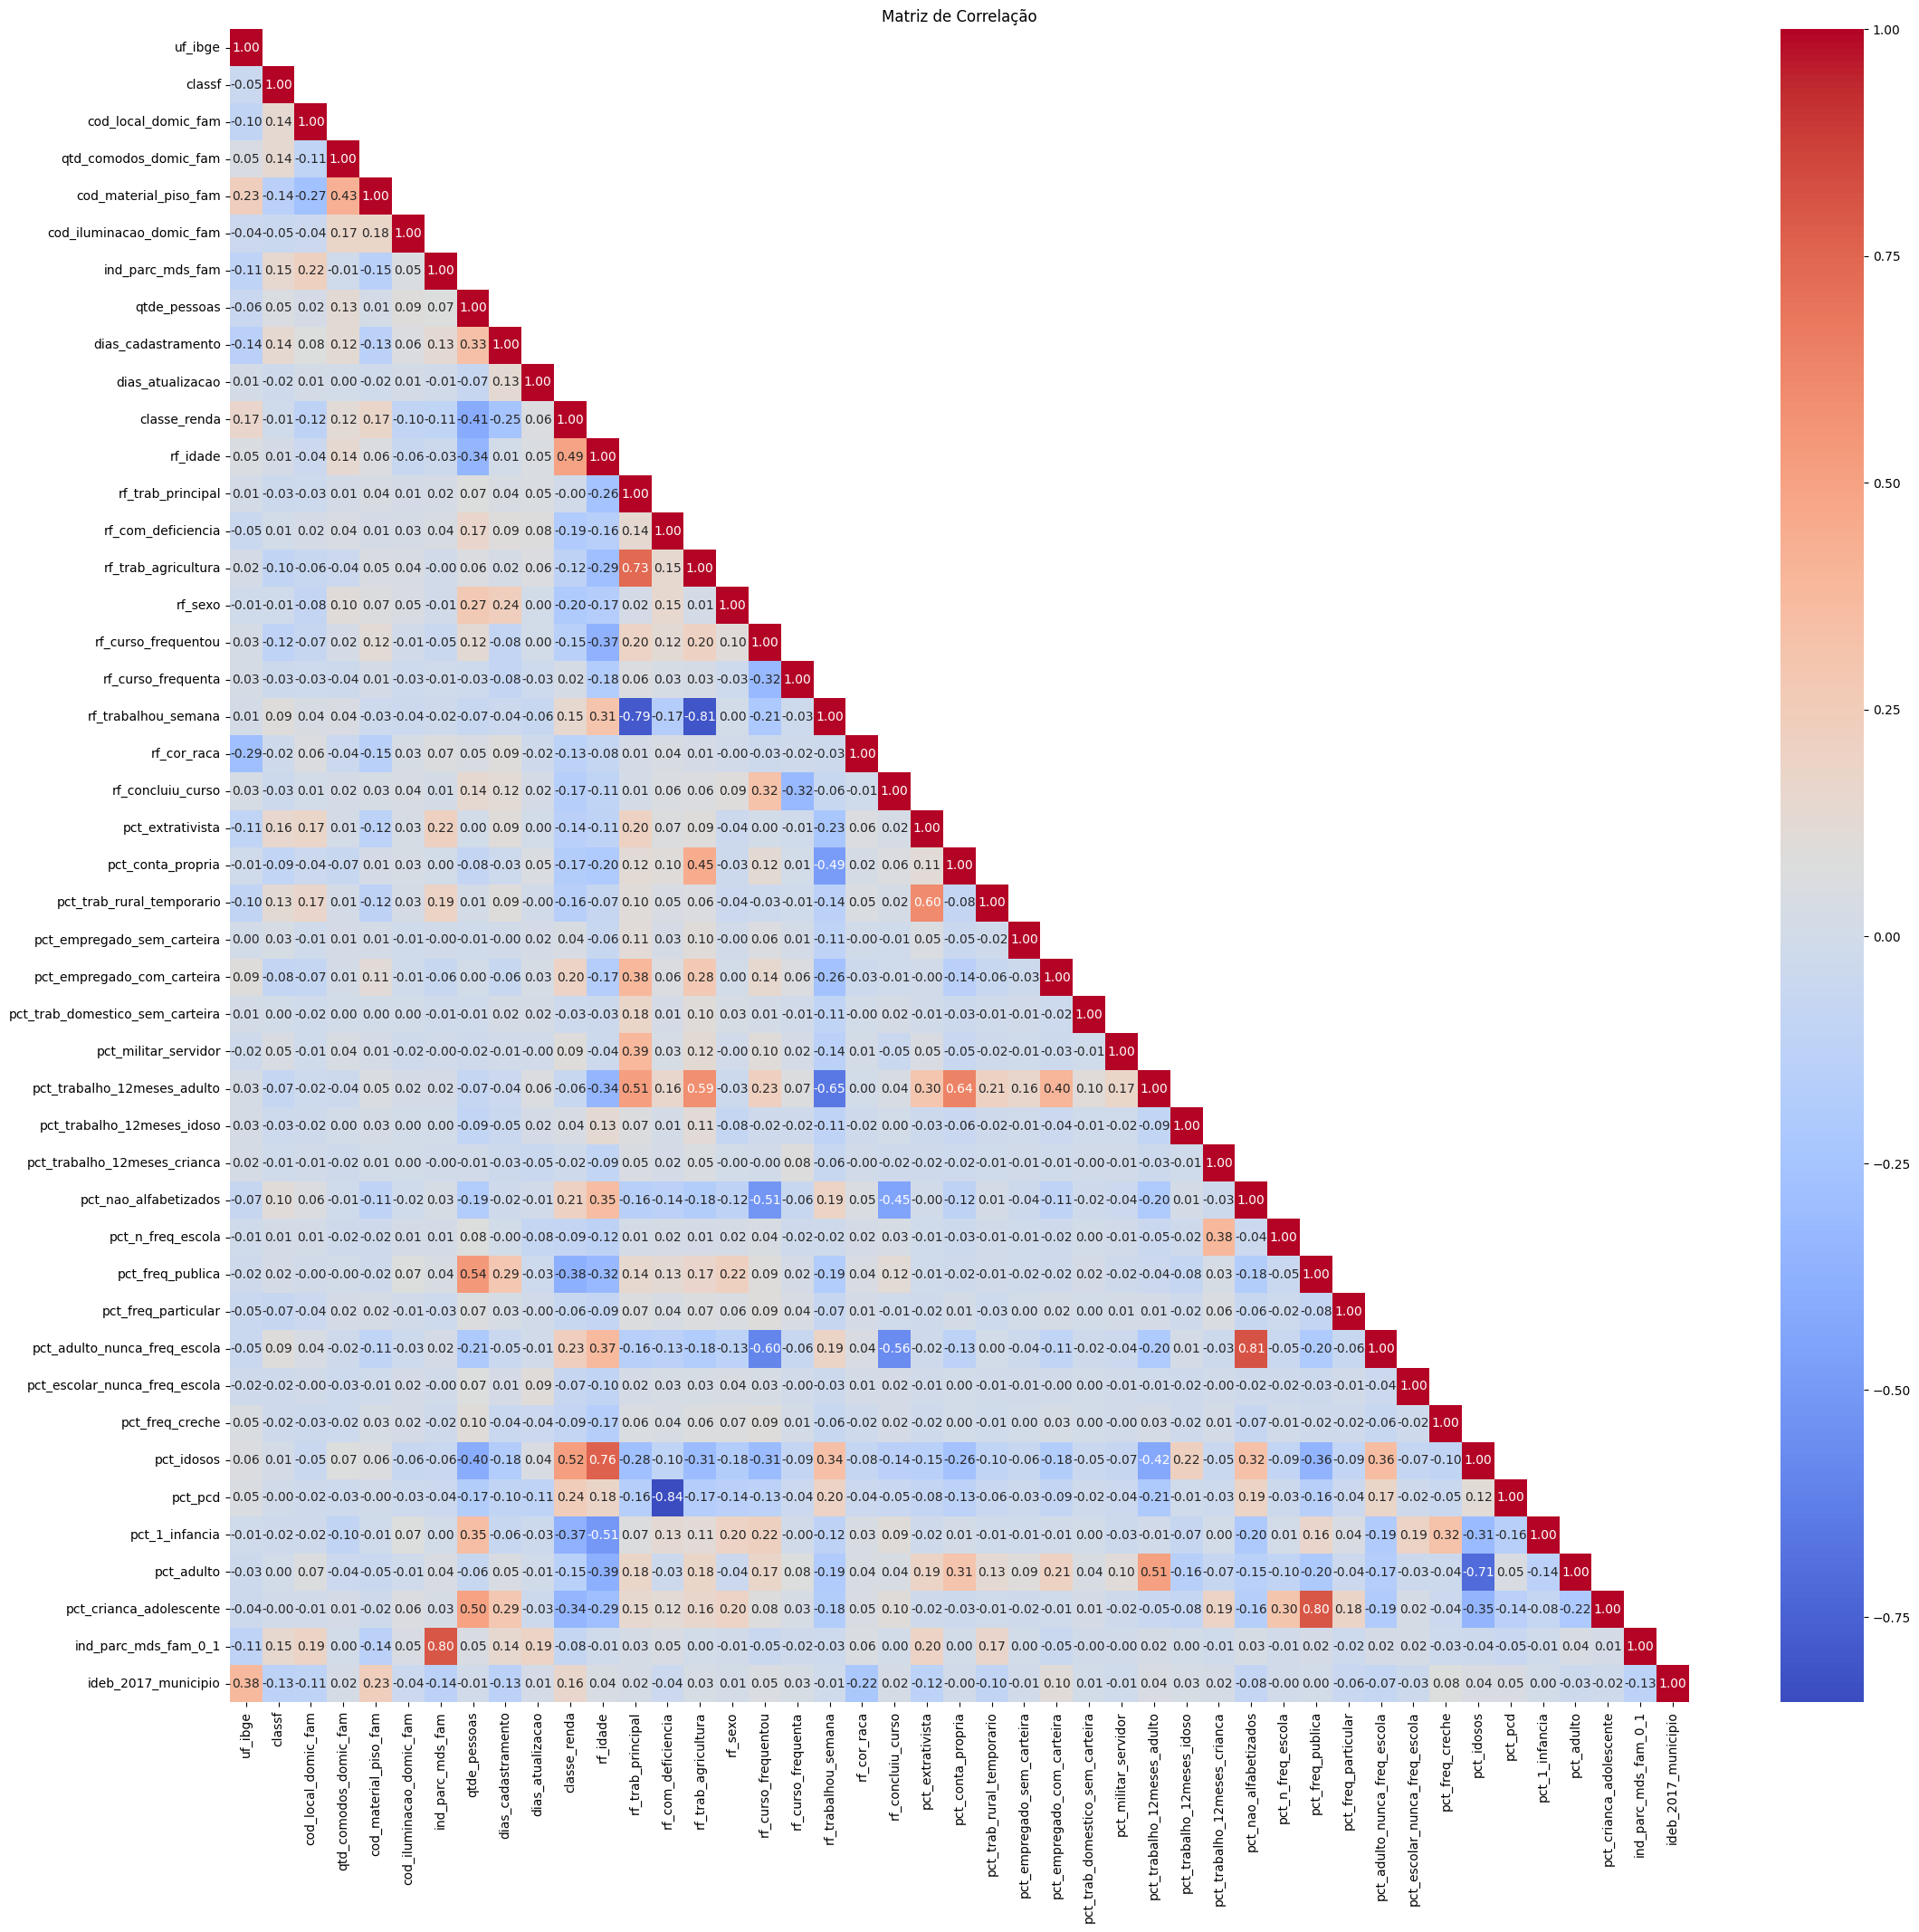

In [8]:
# Verificar a correlação entre as variáveis
plt.figure(figsize=(26, 24))
sns.heatmap(df_fam_featured.corr(), annot=True, cmap='coolwarm', fmt='.2f', mask=mask_fam)
plt.title('Matriz de Correlação')
plt.show()

In [9]:
# Retirar a variável com correlação acima de 0.8
df_fam_featured = df_fam_featured.drop(['rf_com_deficiencia', 'ind_parc_mds_fam_0_1', 'pct_nao_alfabetizados', 'rf_trabalhou_semana'], axis=1)

In [10]:
X = df_fam_featured.drop('classe_renda', axis=1)
y = df_fam_featured['classe_renda']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96792 entries, 0 to 96791
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   uf_ibge                          96792 non-null  int64  
 1   classf                           96792 non-null  int64  
 2   cod_local_domic_fam              96792 non-null  float64
 3   qtd_comodos_domic_fam            96792 non-null  float64
 4   cod_material_piso_fam            96792 non-null  float64
 5   cod_iluminacao_domic_fam         96792 non-null  float64
 6   ind_parc_mds_fam                 96792 non-null  float64
 7   qtde_pessoas                     96792 non-null  int64  
 8   dias_cadastramento               96791 non-null  float64
 9   dias_atualizacao                 96792 non-null  int64  
 10  rf_idade                         96792 non-null  int64  
 11  rf_trab_principal                96792 non-null  float64
 12  rf_trab_agricultur

In [12]:
X.columns

Index(['uf_ibge', 'classf', 'cod_local_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam', 'ind_parc_mds_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_trab_agricultura', 'rf_sexo',
       'rf_curso_frequentou', 'rf_curso_frequenta', 'rf_cor_raca',
       'rf_concluiu_curso', 'pct_extrativista', 'pct_conta_propria',
       'pct_trab_rural_temporario', 'pct_empregado_sem_carteira',
       'pct_empregado_com_carteira', 'pct_trab_domestico_sem_carteira',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_escola',
       'pct_freq_creche', 'pct_idosos', 'pct_pcd', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente', 'ideb_2017_municipio'],
      dtype='obj

In [13]:
X.isnull().sum()

uf_ibge                            0
classf                             0
cod_local_domic_fam                0
qtd_comodos_domic_fam              0
cod_material_piso_fam              0
cod_iluminacao_domic_fam           0
ind_parc_mds_fam                   0
qtde_pessoas                       0
dias_cadastramento                 1
dias_atualizacao                   0
rf_idade                           0
rf_trab_principal                  0
rf_trab_agricultura                0
rf_sexo                            0
rf_curso_frequentou                0
rf_curso_frequenta                 0
rf_cor_raca                        0
rf_concluiu_curso                  0
pct_extrativista                   0
pct_conta_propria                  0
pct_trab_rural_temporario          0
pct_empregado_sem_carteira         0
pct_empregado_com_carteira         0
pct_trab_domestico_sem_carteira    0
pct_militar_servidor               0
pct_trabalho_12meses_adulto        0
pct_trabalho_12meses_idoso         0
p

In [14]:
X = X.fillna(0)

In [15]:
X.isnull().sum()

uf_ibge                            0
classf                             0
cod_local_domic_fam                0
qtd_comodos_domic_fam              0
cod_material_piso_fam              0
cod_iluminacao_domic_fam           0
ind_parc_mds_fam                   0
qtde_pessoas                       0
dias_cadastramento                 0
dias_atualizacao                   0
rf_idade                           0
rf_trab_principal                  0
rf_trab_agricultura                0
rf_sexo                            0
rf_curso_frequentou                0
rf_curso_frequenta                 0
rf_cor_raca                        0
rf_concluiu_curso                  0
pct_extrativista                   0
pct_conta_propria                  0
pct_trab_rural_temporario          0
pct_empregado_sem_carteira         0
pct_empregado_com_carteira         0
pct_trab_domestico_sem_carteira    0
pct_militar_servidor               0
pct_trabalho_12meses_adulto        0
pct_trabalho_12meses_idoso         0
p

## Dividir os dados e criar uma pipeline

In [16]:
categorical_cols = ['rf_idade', 'rf_trab_principal', 'rf_trab_agricultura', 'rf_sexo',
       'rf_curso_frequentou', 'rf_curso_frequenta', 'rf_cor_raca', 'rf_concluiu_curso', 'cod_material_piso_fam', 'cod_iluminacao_domic_fam', 'ind_parc_mds_fam', 'uf_ibge', 'classf', 'cod_local_domic_fam'] 

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rf_idade',
                                                   'rf_trab_principal',
                                                   'rf_trab_agricultura',
                                                   'rf_sexo',
                                                   'rf_curso_frequentou',
                                                   'rf_curso_frequenta',
                                                   'rf_cor_raca',
                                                   'rf_concluiu_curso',
                                                   'cod_material_piso_fam',
                                                   'cod_iluminacao_domic_fam',
                                                   'ind_parc_mds_fam',
                                                   'uf_ibge', 'classf',
                                                   'cod_local_domic_fam'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

### Avaliação do modelo

In [21]:
# Verificar os scores
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      6372
           1       0.64      0.55      0.59      6455
           2       0.76      0.78      0.77      6532

    accuracy                           0.71     19359
   macro avg       0.71      0.71      0.71     19359
weighted avg       0.71      0.71      0.71     19359

Acurácia: 0.7098507154295159
Matriz de Confusão:
 [[5089  883  400]
 [1669 3530 1256]
 [ 348 1061 5123]]


In [23]:
# Ajustar o OneHotEncoder no treino
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

# Verificar as categorias conhecidas após o ajuste
for col, categories in zip(categorical_cols, encoder.categories_):
    print(f"Coluna: {col}, Categorias conhecidas: {categories}")

Coluna: rf_idade, Categorias conhecidas: [ 14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 116 121]
Coluna: rf_trab_principal, Categorias conhecidas: [-1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Coluna: rf_trab_agricultura, Categorias conhecidas: [-1.  1.  2.  9.]
Coluna: rf_sexo, Categorias conhecidas: [1 2]
Coluna: rf_curso_frequentou, Categorias conhecidas: [-1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Coluna: rf_curso_frequenta, Categorias conhecidas: [-1.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
Coluna: rf_trabalhou_semana, Categorias conhecidas: [1. 2.]
Coluna: rf_cor_raca, Categorias conhecidas: [1. 2. 3. 4. 5.]
Coluna: rf_concluiu_curso, Catego

In [24]:
for col, categories in zip(categorical_cols, encoder.categories_):
    unique_test_categories = X_test[col].unique()
    unknown_categories = set(unique_test_categories) - set(categories)
    
    if unknown_categories:
        print(f"Coluna: {col}, Categorias desconhecidas no teste: {unknown_categories}")


Coluna: rf_idade, Categorias desconhecidas no teste: {130, 107}
Coluna: rf_curso_frequenta, Categorias desconhecidas no teste: {1.0}


In [22]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Score:", f1)

F1-Score: 0.7056195991347651


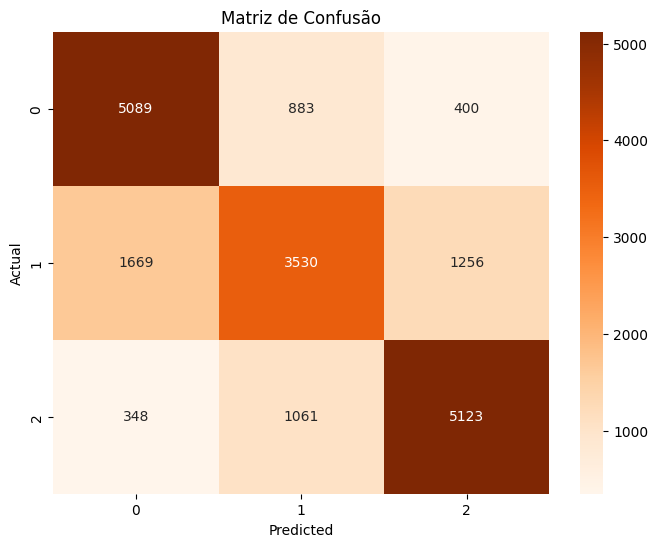

In [23]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

### Buscar melhores hiperparâmetros

In [30]:
# Função para otimizar os hiperparâmetros
def otimizar_hiperparametros(X_train, y_train):
    # Definir os hiperparâmetros a serem testados
    param_grid = {
        'model__penalty': ['l2'],  # L2 é suportado por solvers como 'lbfgs'
        'model__C': [0.1, 1, 10],  # Vários valores para C
        'model__solver': ['lbfgs', 'liblinear'],  # Solvers mais rápidos
        'model__max_iter': [200, 500]  # Número de iterações
    }

    # Usar StratifiedKFold para garantir que cada fold tenha a mesma proporção de classes
    cv = StratifiedKFold(n_splits=3)

    # Criar o GridSearchCV para otimizar o modelo
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Ajustar o modelo com os dados de treino e fazer a busca
    grid_search.fit(X_train, y_train)

    # Obter os melhores parâmetros encontrados
    melhores_parametros = grid_search.best_params_

    # Obter o melhor score de acurácia encontrado
    melhor_score = grid_search.best_score_

    # Retornar os melhores parâmetros, o melhor score e o grid_search
    return melhores_parametros, melhor_score, grid_search

# Exemplo de como chamar a função
melhores_parametros, melhor_score, grid_search = otimizar_hiperparametros(X_train, y_train)

# Exibir os resultados
print("Melhores parâmetros:", melhores_parametros)
print("Melhor acurácia:", melhor_score)

Melhores parâmetros: {'model__C': 0.1, 'model__max_iter': 200, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Melhor acurácia: 0.7120994924644531


### Analisar a importância das variáveis

In [29]:
# Função para calcular a importância das features com o modelo de regressão logística
def calcular_importancia_logistica(model, X_test, y_test):
    # Usar permutation importance para calcular as importâncias
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)  # n_repeats ajusta o número de repetições

    importance_vals = perm_importance.importances_mean  # Importância média
    importance_std = perm_importance.importances_std    # Desvio padrão das importâncias
    feature_importance_df = pd.DataFrame({
        'Feature': X_test.columns,         # Nomes das variáveis
        'Importância': importance_vals,    # Importância média
        'Desvio_Padrao': importance_std    # Desvio padrão
    })

    return feature_importance_df

# Ajustar o modelo de regressão logística
best_model = grid_search.best_estimator_  # Melhor modelo encontrado pelo GridSearchCV

# Calcular a importância das variáveis no conjunto de teste
feature_importance_df = calcular_importancia_logistica(best_model, X_test, y_test)

# Ordenar em ordem decrescente de importância
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)

# Exibir o DataFrame com a importância das variáveis
print(feature_importance_df)

                            Feature  Importância  Desvio_Padrao
22       pct_empregado_com_carteira     0.068681       0.002137
7                      qtde_pessoas     0.047440       0.001774
34                       pct_idosos     0.046051       0.001723
10                         rf_idade     0.038638       0.002769
35                          pct_pcd     0.034046       0.001330
36                   pct_1_infancia     0.028633       0.001255
38          pct_crianca_adolescente     0.023111       0.001705
0                           uf_ibge     0.012470       0.001707
24             pct_militar_servidor     0.009675       0.000653
3             qtd_comodos_domic_fam     0.007216       0.000660
11                rf_trab_principal     0.005212       0.000887
21       pct_empregado_sem_carteira     0.005047       0.000500
15               rf_curso_frequenta     0.003921       0.000465
19                pct_conta_propria     0.003590       0.000427
25      pct_trabalho_12meses_adulto     

### Criar novas divisões para treino e teste após retirar variáveis de menos importância

In [31]:
features_menos_import = feature_importance_df[feature_importance_df['Importância'] < 0.001]['Feature'].tolist()
features_menos_import

['cod_local_domic_fam',
 'pct_trabalho_12meses_idoso',
 'pct_n_freq_escola',
 'pct_adulto_nunca_freq_escola',
 'ideb_2017_municipio',
 'rf_cor_raca',
 'pct_freq_creche',
 'pct_extrativista',
 'cod_iluminacao_domic_fam',
 'pct_escolar_nunca_freq_escola',
 'classf',
 'ind_parc_mds_fam',
 'rf_concluiu_curso',
 'pct_trab_domestico_sem_carteira',
 'rf_trab_agricultura',
 'pct_freq_particular',
 'pct_trabalho_12meses_crianca',
 'rf_sexo',
 'pct_trab_rural_temporario']

In [32]:
df_fam_featured_2 = df_fam_featured.drop(features_menos_import, axis=1)

In [33]:
X_2 = df_fam_featured_2.drop('classe_renda', axis=1)
y_2 = df_fam_featured_2['classe_renda']

In [34]:
X_2.columns

Index(['uf_ibge', 'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'qtde_pessoas', 'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_curso_frequentou', 'rf_curso_frequenta',
       'pct_conta_propria', 'pct_empregado_sem_carteira',
       'pct_empregado_com_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_freq_publica', 'pct_idosos',
       'pct_pcd', 'pct_1_infancia', 'pct_adulto', 'pct_crianca_adolescente'],
      dtype='object')

In [41]:
X_2 = X_2.fillna(0)

In [35]:
categorical_cols_2 = ['uf_ibge', 'cod_material_piso_fam', 'rf_idade', 'rf_trab_principal', 'rf_curso_frequentou', 'rf_curso_frequenta']

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_2)],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [44]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['uf_ibge',
                                                   'cod_material_piso_fam',
                                                   'rf_idade',
                                                   'rf_trab_principal',
                                                   'rf_curso_frequentou',
                                                   'rf_curso_frequenta'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

In [46]:
# Verificar os scores
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      6372
           1       0.65      0.54      0.59      6455
           2       0.75      0.78      0.77      6532

    accuracy                           0.71     19359
   macro avg       0.70      0.71      0.70     19359
weighted avg       0.70      0.71      0.70     19359

Acurácia: 0.7076811818792293
Matriz de Confusão:
 [[5131  827  414]
 [1749 3463 1243]
 [ 379 1047 5106]]


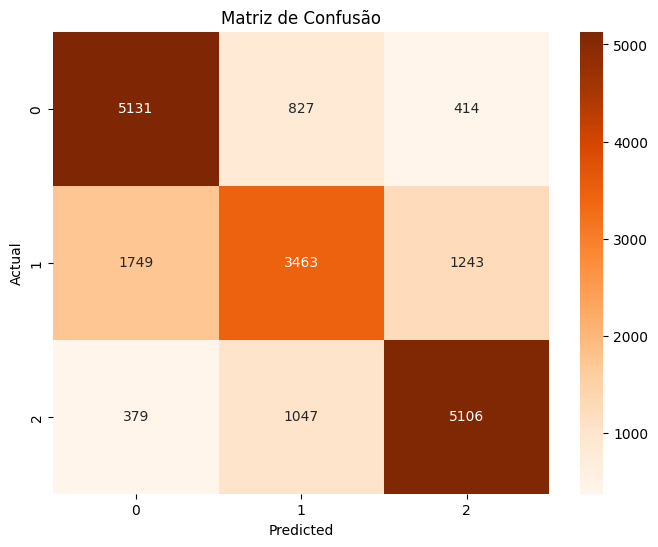

In [47]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

In [48]:
melhores_parametros, melhor_score = otimizar_hiperparametros(X_train, y_train)

# Exibir os resultados
print("Melhores parâmetros:", melhores_parametros)
print("Melhor acurácia:", melhor_score)

Melhores parâmetros: {'model__C': 10, 'model__max_iter': 200, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Melhor acurácia: 0.706133044050986
